# Практическая часть ДЗ 1. Удаление фона с помощью SVD (35 баллов)

Версия от 20.01.21.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.

In [2]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
video.fps

23.976023976023978

In [5]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(np.float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


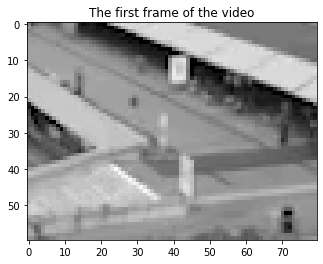

In [6]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
_ = plt.title('The first frame of the video')

### a. Применение базового алгоритма SVD (15 баллов)

1. **(3 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```nframes x (size_h * size_w)```, каждой строкой которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

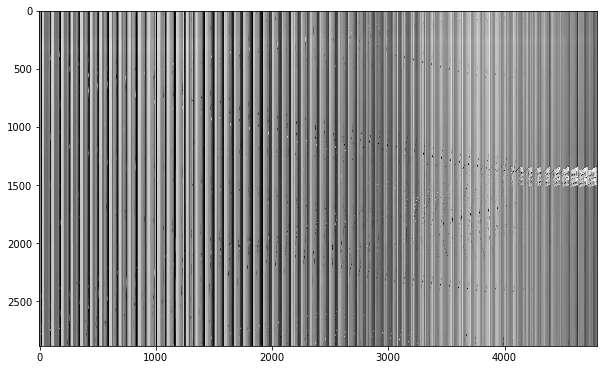

In [7]:
nframes, size_w, size_h = arr.shape
M = arr.reshape(nframes, size_h * size_w)

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray')

In [8]:
M_ = arr.reshape(nframes, size_h * size_w) # На будущее

2. **(5 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Комментарий: согл, есть такое.

In [10]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
greatest = S[0]
S /= greatest

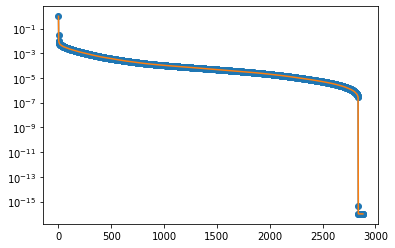

In [11]:
plt.plot(S, '-o')
plt.yscale('log')
plt.semilogy(S)

*Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных.*\
Наибольшее сингулярное число соответствует второй норме матрицы, разложение которой было получено. Сама по себе норма - неотрицательная величина, а в конце мы еще на нее разделили, тем самым нормировав показания, поэтому $\sigma_1$ = 1. Остальные же числа близки к нулю, однако последние значения характеризуются приколами с вычислительной точностью.

3. **(5 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в матричной 2-норме, т.е. $$
\frac{\|M - M_{r}\|_2}{\|M\|_2}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

https://learnmachinelearning.wikia.org/ru/wiki/Сокращённое_сингулярное_разложение

Можно было бы по приколу заморочиться, и написать функцию, вычисляющую оптимальный k по минимизации относительной ошибки, но раз просят найти для определенного ранга, найдем для определенного ранга.

In [12]:
def trunc_svd(M, r):
    
    # SVD от M
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    
    # Представим S как матрицу
    Sigma = np.diag(S)
    
    # Вторая норма равна старшему сингулярному числу, значит
    M_norm_2 = Sigma[0][0]

    Sigma_r = Sigma[:r, :r]   
    U_r = U[:, :r]
    Vt_r = Vt[:r, :]
            
    M_r = U_r @ Sigma_r @ Vt_r
    
    # Если из Sigma вычесть полученную матрицу ранга r того же размера,
    # то первые r элементов на диагонали занулятся, и наибольшим станет значение
    # под индексом [r][r] - это связано с M - M_r
    M_r_norm_2 = Sigma[r][r]
    rel_eps = M_r_norm_2 / M_norm_2
    
    return M_r, rel_eps
    
    # raise NotImplementedError()

4. **(2 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [13]:
M_svd, error = trunc_svd(M, 1)

In [14]:
print(error)
#print(M_svd)

0.03010607082731466


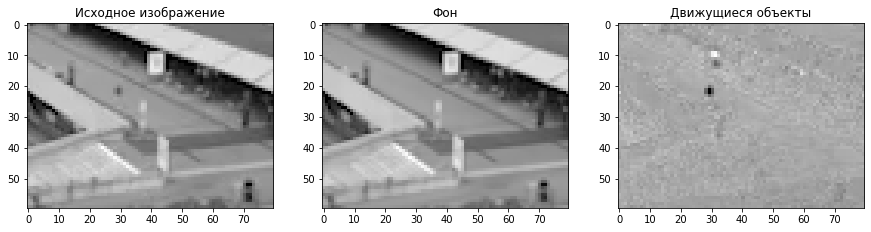

In [15]:
_, axs = plt.subplots(1,3, figsize=(15,10))

frame_number = 0

frame = M[frame_number]
axs[0].imshow(frame.reshape(60, 80), cmap='gray')
axs[0].set_title("Исходное изображение")

frame_bg = M_svd[frame_number]
axs[1].imshow(frame_bg.reshape(60, 80), cmap='gray')
axs[1].set_title("Фон")

frame_obj = (M - M_svd)[frame_number]
axs[2].imshow(frame_obj.reshape(60, 80), cmap='gray')
_ = axs[2].set_title("Движущиеся объекты")

Навыки фотошопа помогли, найс. В целом, результат вышел интересным - неожиданно, что урезание разложения так влияет на объект.

### b. Применение рандомизированного алгоритма SVD (14 баллов)

Загрузим теперь видео в более высоком разрешении.

In [16]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [17]:
arr = video_to_array(video)
nframes, size_w, size_h = arr.shape
M = arr.reshape(nframes, size_h * size_w)

image size: 100 x 178, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(8 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм заспускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [18]:
def rand_svd(M, r, oversampling=10):
    
    m, n = M.shape[0], M.shape[1]
    Omega = np.random.normal(size=(n, r + oversampling))

    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    W, S, Vt = np.linalg.svd((Q.T @ M), full_matrices=False)
    
    Sigma = np.diag(S)
    M_norm_2 = Sigma[0][0]

    Sigma_r = Sigma[:r, :r]   
    W_r = W[:, :r]
    Vt_r = Vt[:r, :]
            
    M_r = Q @ W_r @ Sigma_r @ Vt_r
    
    # rel_esp = np.linalg.norm(M - M_r, ord = 2) / np.linalg.norm(M, ord = 2)
    rel_esp = 0
    
    return M_r, rel_esp
    #raise NotImplementedError()

2. **(1 балла)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [19]:
M_rand, error = rand_svd(M, 1)
print('Done')
# Данную строчку можно было бы внести в функцию, и все спокойно бы работало, но
# так сделано с целью сравнить работу этой функции с trunc_svd, так как 
# там ошибка считалась другим путем, и это занимало мало времени, здесь же так не выйдет
# linalg.norm заставляет мой браузер вылетать на орбиту за пределы винды и вообще любых ОС,
# поэтому подсчет ошибки я вынес за пределы функции
# В самой же функции я оставил комментарий - можно раскомментировать и убрать rel_esp = 0
# Просьба не бить, а понять и простить
error = np.linalg.norm(M - M_rand, ord = 2) / np.linalg.norm(M, ord = 2)
print(error)
#print(M_rand)

Done
0.01361977833069856


Работает значительно быстрее.

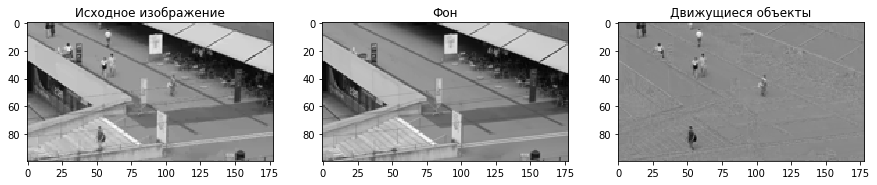

In [20]:
_, axs = plt.subplots(1,3, figsize=(15,10))
frame_number = 0

frame = M[frame_number]
axs[0].imshow(frame.reshape(100, 178), cmap='gray')
axs[0].set_title("Исходное изображение")

frame_bg = M_rand[frame_number]
axs[1].imshow(frame_bg.reshape(100, 178), cmap='gray')
axs[1].set_title("Фон")

frame_obj = (M - M_rand)[frame_number]
axs[2].imshow(frame_obj.reshape(100, 178), cmap='gray')
_ = axs[2].set_title("Движущиеся объекты")

3. **(5 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой. 

Обратите внимание, что в отличии от задачи a.3 мы используем норму Фробениуса для расчета ошибки, так как $\|\cdot\|_2$ требует вычисления $\sigma_1(A)$, а значит и всего SVD, что было бы неэффективно для этих размеров матриц.

In [21]:
def foo(M, r, oversampling=10):
    res = 0
    for _ in range(10):
        M_rand, _ = rand_svd(M, r, oversampling)
        res += np.linalg.norm(M_rand - M, ord = 'fro') / np.linalg.norm(M, ord = 'fro')
  
    return res / 10

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


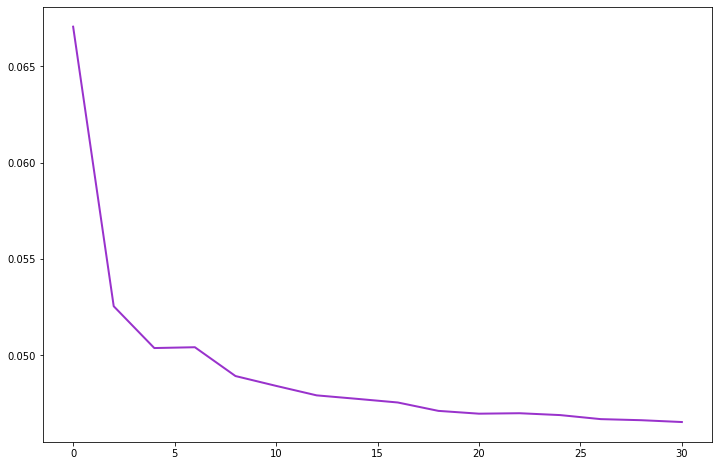

In [22]:
p_lsp = [ 2 * i for i in range(30 // 2 + 1) ]
print(p_lsp)
foo_points = [ foo(M, 2, p) for p in p_lsp]

plt.figure(figsize=(12, 8))
plt.plot(p_lsp, foo_points, 'darkorchid', label = 'Error', linewidth = 2)

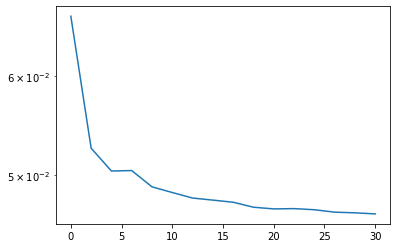

In [23]:
plt.semilogy(p_lsp, foo_points)

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгортм. Обратите также внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может также случиться переполнение по памяти. 

### c. Видео с переменным освещением (4 балла)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [24]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [25]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```nframes2 x (size_h * size_w)```. 

(2883, 60, 80)


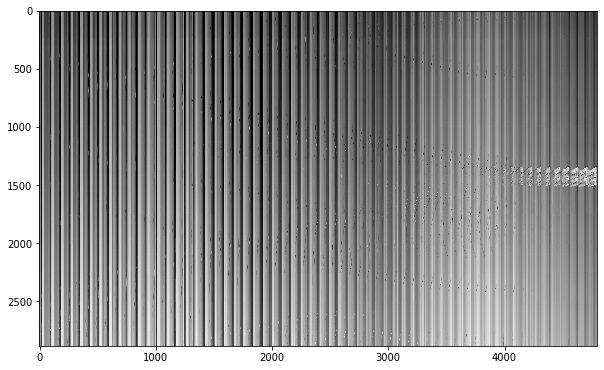

In [26]:
nframes2, size_w, size_h = arr2.shape
print(arr2.shape)
M2 = arr2.reshape(nframes2, size_h * size_w)

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray')

2. **(1 балл)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`.

In [27]:
def full_svd(M, r):

    U, S, Vt = np.linalg.svd(M)

    Sigma = np.diag(S)

    M_norm_2 = Sigma[0][0]

    Sigma_r = Sigma[:r, :r]   
    U_r = U[:, :r]
    Vt_r = Vt[:r, :]
            
    M_r = U_r @ Sigma_r @ Vt_r

    M_r_norm_2 = Sigma[r][r]
    rel_eps = M_r_norm_2 / M_norm_2
    
    return M_r, rel_eps

    
def full_rand_svd(M, r, oversampling=10):
    
    m, n = M.shape[0], M.shape[1]
    Omega = np.random.normal(size=(n, r + oversampling))

    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    W, S, Vt = np.linalg.svd((Q.T @ M))
    
    Sigma = np.diag(S)
    M_norm_2 = Sigma[0][0]

    Sigma_r = Sigma[:r, :r]   
    W_r = W[:, :r]
    Vt_r = Vt[:r, :]
            
    M_r = Q @ W_r @ Sigma_r @ Vt_r
    
    # rel_esp = np.linalg.norm(M - M_r, ord = 2) / np.linalg.norm(M, ord = 2)
    rel_esp = 0
    
    return M_r, rel_esp

In [28]:
M2_svd, _ = full_svd(M2, 2)
M2_rand, _ = full_rand_svd(M2, 2)

3. **(1 балл)** Вычислите относительную точность такого приближения в норме Фробениуса и сравните её с соответствующей величиной для видео с постоянным освещением.

In [29]:
# С освещением
acc_M2 = np.linalg.norm(M2, ord = 'fro')
acc_M2_rnd = np.linalg.norm(M2_rand - M2, ord = 'fro') / acc_M2
acc_M2_svd = np.linalg.norm(M2_svd - M2, ord = 'fro') / acc_M2

# Без освещения
acc_M_ = np.linalg.norm(M_, ord = 'fro')

M_svd_, _ = full_svd(M_, 2)
M_rand_, _ = full_rand_svd(M_, 2)

acc_M_rnd_ = np.linalg.norm(M_rand_ - M_, ord = 'fro') / acc_M_
acc_M_svd_ = np.linalg.norm(M_svd_ - M_, ord = 'fro') / acc_M_

print('Lightning accuracy: ', acc_M2_rnd, acc_M2_svd)
print('NoLightning accuracy: ', acc_M_rnd_, acc_M_svd_)

Lightning accuracy:  0.059708958535845194 0.05459538505504911
NoLightning accuracy:  0.051630358474976996 0.04685531156553081


4. **(2 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [30]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[0]
    arr = M.reshape(nframes, size_w, size_h) # FIX
    
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [31]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

Не хочу.

### d. Robust PCA (2 балла)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутвия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

1. Скачайте код для вычисления robust PCA по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируйте его.

In [1]:
from modules import r_pca
from r_pca import R_pca

Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(2 балла)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [11]:
Mt = M_[:M_.shape[0] // 4:2, :]
solver = r_pca.R_pca(Mt, mu=0.68)
L, S = solver.fit(max_iter=4000, iter_print=100)

iteration: 1, error: 10.068199117427543
iteration: 100, error: 0.7004423976789355
iteration: 200, error: 0.42632079958604574
iteration: 300, error: 0.2861554334252998
iteration: 400, error: 0.1976376299758995
iteration: 500, error: 0.1491945127519798
iteration: 600, error: 0.11977761026369248
iteration: 700, error: 0.10258379641122532
iteration: 800, error: 0.08740324641255255
iteration: 900, error: 0.07772202032053402
iteration: 1000, error: 0.06319242192754794
iteration: 1100, error: 0.0572775616708379
iteration: 1200, error: 0.0436196318456162
iteration: 1300, error: 0.042779181567643855
iteration: 1400, error: 0.028313363621304377
iteration: 1500, error: 0.02821559228171161
iteration: 1546, error: 0.017703452885420707


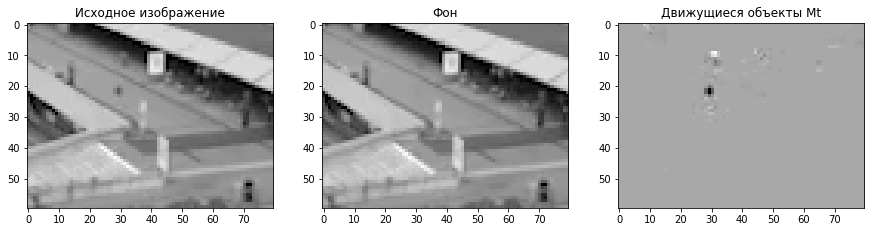

In [12]:
_, axs = plt.subplots(1,3, figsize=(15,10))
frame_number = 0

frame = Mt[frame_number]
axs[0].imshow(frame.reshape(60, 80), cmap='gray')
axs[0].set_title("Исходное изображение")

frame = (L)[frame_number]
axs[1].imshow(frame.reshape(60, 80), cmap='gray')
axs[1].set_title("Фон")

frame = (S)[frame_number]
axs[2].imshow(frame.reshape(60, 80), cmap='gray')
_ = axs[2].set_title("Движущиеся объекты Mt")